<h3>P4: Guarda se fa freddo </h3> <p>
Il dataset GlobalLandTemperaturesByMajorCity.csv riporta la temperatura registrata nelle maggiori città del mondo a partire dal 1750. Usando questi dati, il progetto dovrà fornire una visualizzazione grafica efficace del variare delle temperature nel tempo, evidenziando le città in cui si sono registrate le maggiori escursioni termiche nei diversi periodi storici. Per la visualizzazione dei dati su mappa si veda geopandas. Il programma inoltre dovrà suggerire, a seconda del periodo considerato, il percorso migliore da seguire per un viaggatore freddoloso che intenda spostarsi da Pechino a Los Angeles muovendosi tappa dopo tappa verso la città più calda fra le 3 a lui più vicine.

In [1]:
#importo le librerie utilizzate nel progetto
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta

In [2]:
#importo il dataset
df = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')
# rinomino alcune colonne
df = df.rename(columns={'dt':'Date', 'AverageTemperature':'AvgTemp', 'AverageTemperatureUncertainty':'AvgTempUnc'})

In [3]:
# trovo i valori nulli
df.isnull().sum(axis=0)

Date              0
AvgTemp       11002
AvgTempUnc    11002
City              0
Country           0
Latitude          0
Longitude         0
dtype: int64

In [4]:
# converto il formato della colonna data e creo una colonna contenente per ogni riga l'anno di riferimento
df['Date']= pd.to_datetime(df['Date'])
df['Year']=df['Date'].dt.year

In [5]:
# elimino dal dataset le righe contenenti valori nulli (tutti telativi alla temperature) e faccio partire il dataset dal 1750
df = df.dropna(axis=0)
df = df[df['Year'] >= 1750]
df

,Date,AvgTemp,AvgTempUnc,City,Country,Latitude,Longitude,Year
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849
...,...,...,...,...,...,...,...,...
239171,2013-04-01,12.563,1.823,Xian,China,34.56N,108.97E,2013
239172,2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E,2013
239173,2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E,2013
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E,2013


In [6]:
# pulisco le coordinate di latinutedine e longitudine per fare in modo che contengano valori solo numerici, inizio 
# ridefinendo le due colonnne come stringhe

df['Latitude'] = df['Latitude'].astype(str)
df['Longitude'] = df['Longitude'].astype(str)

# definisco una funzione che converta le stringhe a float e renda negative le latitudini quando sono a sud (contengono la S)

def convert_latitude(x):
    num_str = re.findall(r'\d+\.\d+', x)[0]
    num = float(num_str)
    if x.endswith('S'):
        num *= -1
    return num
df['Latitude'] = df['Latitude'].apply(convert_latitude)

# definisco una funzione che converta le stringhe a float e le renda negative le longitudini quando 
# sono a ovest (contengono la W)

def convert_longitude(x):
    num_str = re.findall(r'\d+\.\d+', x)[0]
    num = float(num_str)
    if x.endswith('W'):
        num *= -1
    return num
df['Longitude'] = df['Longitude'].apply(convert_longitude)

df

,Date,AvgTemp,AvgTempUnc,City,Country,Latitude,Longitude,Year
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63,-3.23,1849
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63,-3.23,1849
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63,-3.23,1849
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63,-3.23,1849
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63,-3.23,1849
...,...,...,...,...,...,...,...,...
239171,2013-04-01,12.563,1.823,Xian,China,34.56,108.97,2013
239172,2013-05-01,18.979,0.807,Xian,China,34.56,108.97,2013
239173,2013-06-01,23.522,0.647,Xian,China,34.56,108.97,2013
239174,2013-07-01,25.251,1.042,Xian,China,34.56,108.97,2013


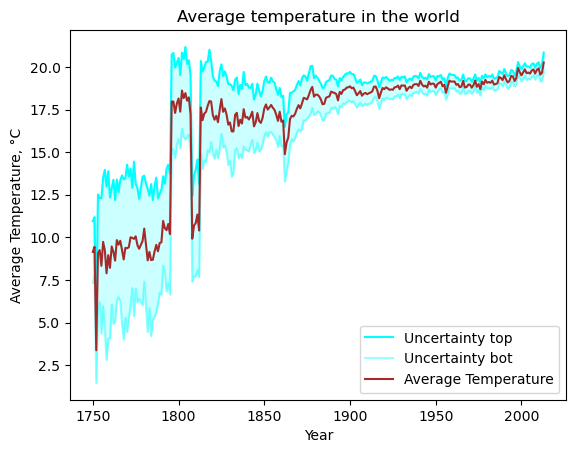

In [7]:
# creo una prima rappresentazione grafica dei dati

# estraggo tutti gli anni presenti
years = np.unique(df['Year'])

#creo due liste vuote per temperatura media e incertezza
mean_temp = []
mean_temp_unc = []

# trovo per ogni anno la temperatura media e l'incertezza media
for year in years:
    mean_temp.append(df[df['Year'] == year]['AvgTemp'].mean())
    mean_temp_unc.append(df[df['Year'] == year]['AvgTempUnc'].mean())

# plotto i dati per avere un'idea dell'andamento, sommando e sottraendo l'incertezza media dalla media delle temperature
fig, ax = plt.subplots()
ax.plot(years, np.array(mean_temp) + np.array(mean_temp_unc),
        label='Uncertainty top', color='cyan')
ax.plot(years, np.array(mean_temp) - np.array(mean_temp_unc),
        label='Uncertainty bot', color='cyan', alpha=0.4)
ax.fill_between(years, np.array(mean_temp) + np.array(mean_temp_unc),
                np.array(mean_temp) - np.array(mean_temp_unc), color='cyan', alpha=0.2)
ax.plot(years, mean_temp, label='Average Temperature', color='brown')

ax.set_xlabel('Year')
ax.set_ylabel('Average Temperature, °C')
ax.set_title('Average temperature in the world')
ax.legend()

ax.set_xticks(years[::50])
plt.show()


In [8]:
# eseguo alcune modifiche sul dataframe:

# raggruppo per città e anno e inserisco due colonne relative alle temperature max e min annuali
df_groups = df.groupby(['City', df['Date'].dt.year]).agg({'AvgTemp': ['max', 'min', 'mean'], 'AvgTempUnc': 'first', 
                                                          'Country': 'first', 'Latitude': 'first', 'Longitude': 'first'
                                                         }).reset_index()

# sistemo i nomi delle colonne del dataset
df_groups.columns = ['City', 'Year', 'MaxTemp', 'MinTemp', 'AvgTemp', 'AvgTempUnc', 'Country', 'Latitude', 'Longitude']

# inserisco la colonna dell'escursione termica annuale
df_groups['TempExc'] = df_groups['MaxTemp'] - df_groups['MinTemp']

# definisco l'anno come intero
df_groups['Year'] = df_groups['Year'].astype(int)


df_groups

,City,Year,MaxTemp,MinTemp,AvgTemp,AvgTempUnc,Country,Latitude,Longitude,TempExc
0,Abidjan,1849,28.101,23.576,25.582583,1.435,Côte D'Ivoire,5.63,-3.23,4.525
1,Abidjan,1850,27.890,23.758,25.518250,1.943,Côte D'Ivoire,5.63,-3.23,4.132
2,Abidjan,1851,27.363,23.752,25.672333,1.249,Côte D'Ivoire,5.63,-3.23,3.611
3,Abidjan,1856,27.297,24.031,26.277333,1.270,Côte D'Ivoire,5.63,-3.23,3.266
4,Abidjan,1857,27.299,23.264,25.169091,1.749,Côte D'Ivoire,5.63,-3.23,4.035
...,...,...,...,...,...,...,...,...,...,...
19158,Xian,2009,25.500,-1.516,12.528417,0.425,China,34.56,108.97,27.016
19159,Xian,2010,25.722,-0.237,12.589750,0.554,China,34.56,108.97,25.959
19160,Xian,2011,24.895,-4.811,12.075167,0.559,China,34.56,108.97,29.706
19161,Xian,2012,24.646,-2.416,11.898167,0.568,China,34.56,108.97,27.062


In [9]:
# osservo tutte le città considerate ed estraggo l'anno di introduzine nel dataset di ciascuna città
first_year_by_city = df.groupby('City')['Date'].agg(lambda x: x.min().year)
first_year_by_city = first_year_by_city.sort_values()
pd.set_option('display.max_rows', 100)
print(first_year_by_city)

City
New York            1750
Chicago             1750
Paris               1750
Madrid              1750
London              1750
Montreal            1750
Berlin              1750
Saint Petersburg    1750
Rome                1750
Kiev                1750
Istanbul            1750
Toronto             1750
Moscow              1750
Izmir               1753
Ankara              1755
Casablanca          1763
Alexandria          1791
Aleppo              1791
Surat               1796
Lakhnau             1796
Madras              1796
Dhaka               1796
Delhi               1796
Hyderabad           1796
Jaipur              1796
New Delhi           1796
Ahmadabad           1796
Bangalore           1796
Bombay              1796
Nagpur              1796
Rangoon             1796
Pune                1796
Karachi             1796
Calcutta            1796
Kanpur              1796
Gizeh               1808
Cairo               1808
Faisalabad          1816
Lahore              1816
Bangkok             

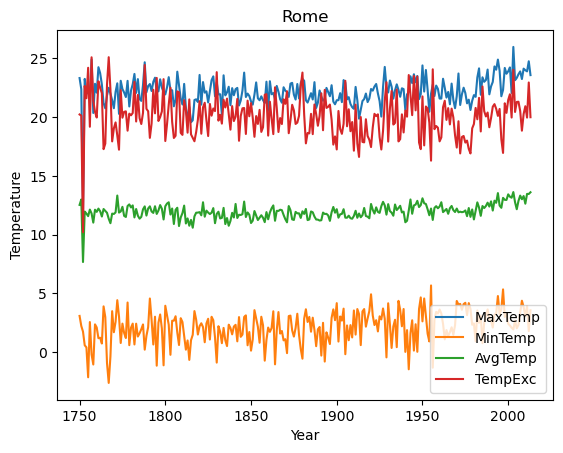

In [10]:
# definisco una funzione che scegliendo la città plotta i relativi dati 

def city_plot(name):
    city_group = df_groups[df_groups['City']==name]
    plt.plot(city_group['Year'], city_group['MaxTemp'], label='MaxTemp')
    plt.plot(city_group['Year'], city_group['MinTemp'], label='MinTemp')
    plt.plot(city_group['Year'], city_group['AvgTemp'], label='AvgTemp')
    plt.plot(city_group['Year'], city_group['TempExc'], label='TempExc')
    plt.title(name)
    plt.xlabel('Year')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()
    
city_plot('Rome')

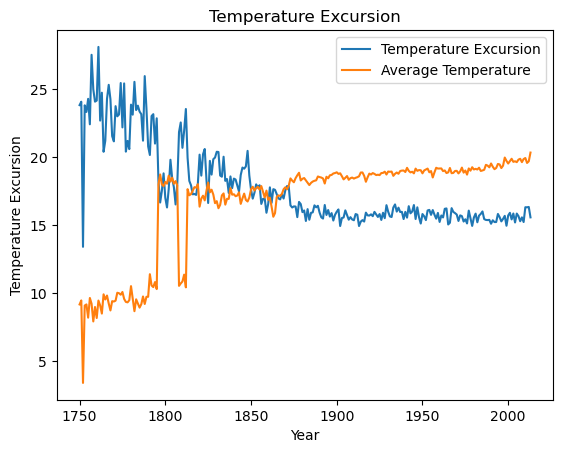

In [11]:
# raggruppo i dati per anno e visualizzo la temperatura media e l'escursione termica per ciascuno 

grouped = df_groups.groupby('Year').mean(numeric_only=True)

plt.plot(grouped.index, grouped['TempExc'])
plt.plot(grouped.index, grouped['AvgTemp'])
plt.title('Temperature Excursion')
plt.xlabel('Year')
plt.ylabel('Temperature Excursion')
plt.legend(labels=['Temperature Excursion', 'Average Temperature'])
plt.show()

In [12]:
def temp_range_by_country3(df): 
    
    # seleziono le temperature minime e massime per ogni città e arrotondo i valori
    df_range = df.groupby('City').agg({'MinTemp': 'min', 'MaxTemp': 'max'})
    df_range = df_range.round(1)
    
    #creo un grafico a barre che rappresenta la temperatura minima e la massima registrata nel dataset per ogni città
    fig, ax = plt.subplots(figsize=(15, 25))
    ax.barh(df_range.index, df_range['MaxTemp']-df_range['MinTemp'], left=df_range['MinTemp'], color='lightblue')
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('City')
    ax.set_title('Temperature Range by City')
    ax.grid(True, axis='x')
    
    for i, (min_temp, max_temp) in enumerate(zip(df_range['MinTemp'], df_range['MaxTemp'])):
        ax.text(max_temp, i, f'{max_temp}°C', va='center', ha='left', color='black')
        ax.text(min_temp, i, f'{min_temp}°C', va='center', ha='right', color='black')
        
    fig.tight_layout()
    plt.show()



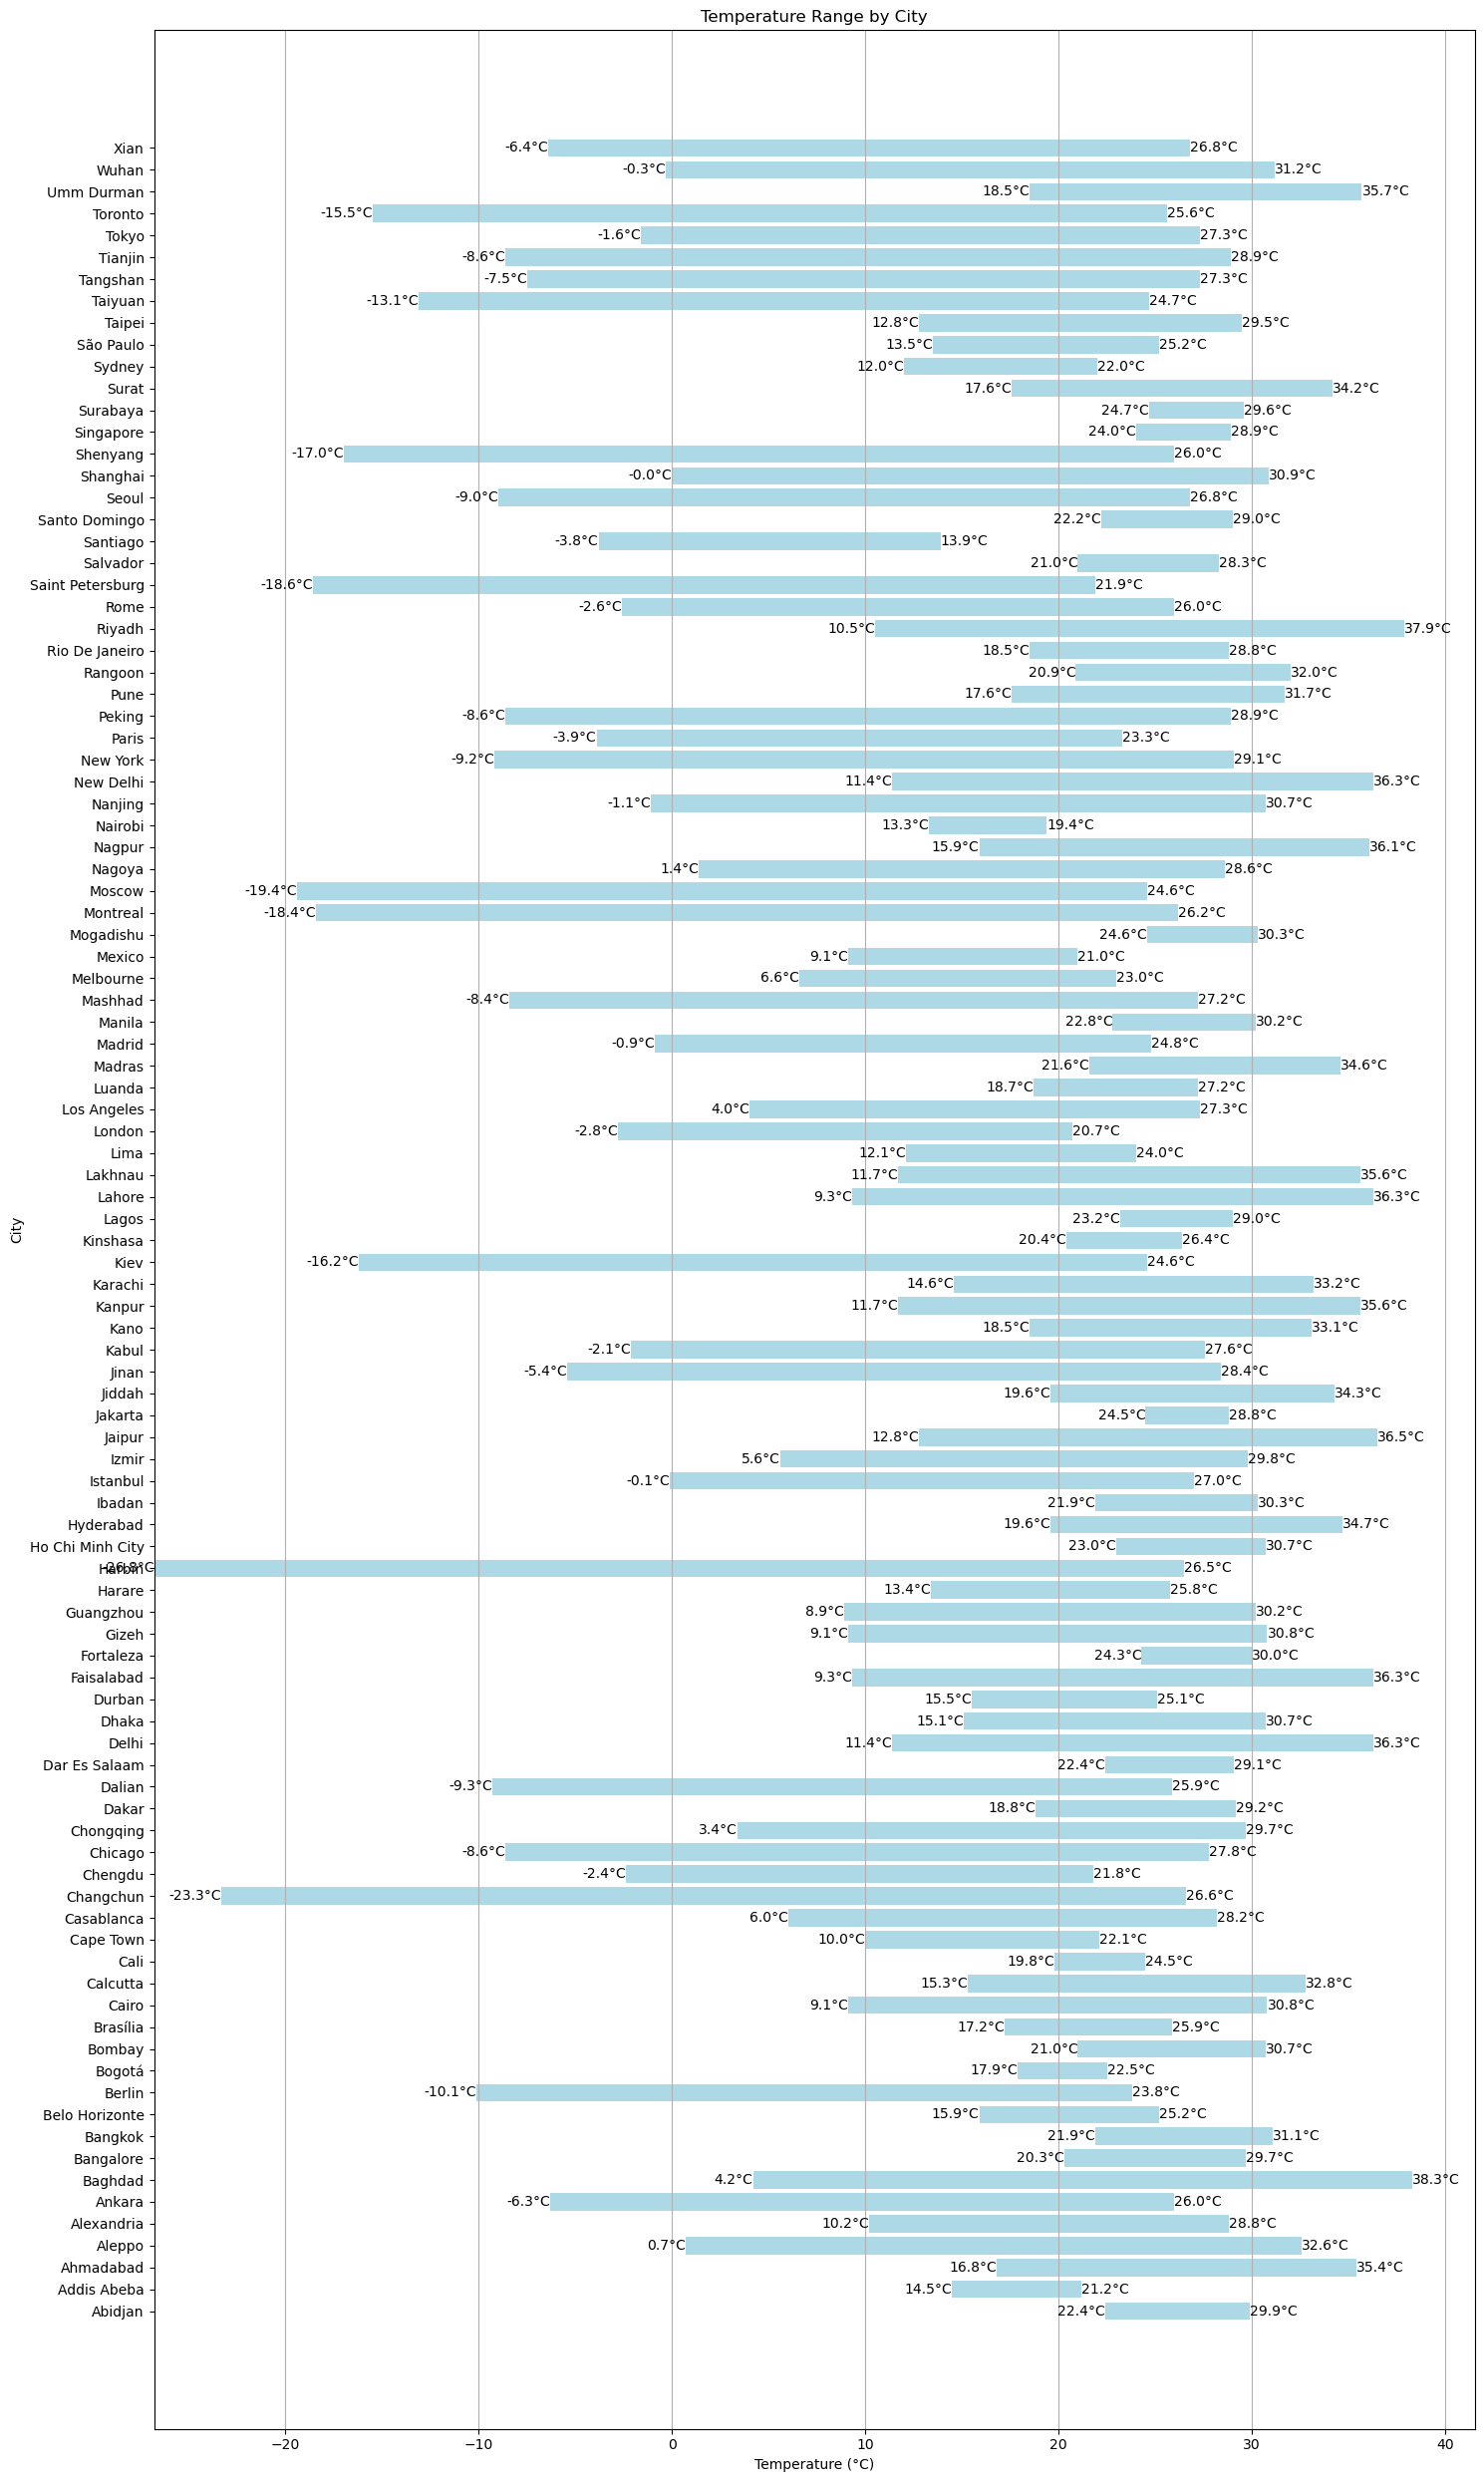

In [13]:
temp_range_by_country3(df_groups)

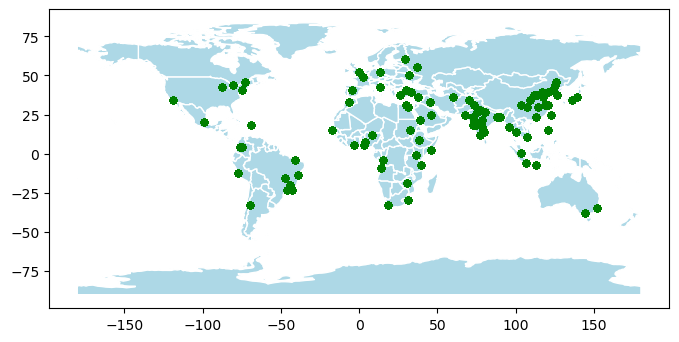

In [14]:
# plotto una mappa contenente i punti di tutti e 100 i paesi considerati dal Geodataframe

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(figsize=(8, 4), edgecolor='white', facecolor='lightblue')
gdf.plot(ax=ax, color='green', markersize=20)

plt.show()

In [15]:
# definisco una funzione che torva i periodi nei quali è stato osservato il maggior numero di escursioni termiche
# ha come argomenti il dataframe e il numero di anni in cui raggrupparlo per effettuare l'osservazione

def temp_exc_by_period(df, n):
    #raggruppo il dataset secondo il numero di anni n definito e trovo l'escursione termica media sul periodo
    df_grouped = df.groupby(['City', (df['Year'] // n) * n, 'Latitude', 'Longitude']).agg({'MaxTemp': 'max', 'MinTemp': 'min'})
    df_grouped['TempExc'] = df_grouped['MaxTemp'] - df_grouped['MinTemp']
    df_grouped = df_grouped.reset_index()

    # prendo le 10 maggiori escursioni termiche per ogni città nel periodo n anni
    df_excursions = df_grouped.groupby('City').apply(lambda x: x.nlargest(5, ['TempExc']))
    df_excursions = df_excursions.dropna(axis=0)
    
    # trovo i 20 periodi che rilveano il maggior numero di escursioni termiche
    counts = df_excursions['Year'].value_counts().reset_index().rename(columns={'index': 'Year', 'Year': 'Count'})
    top20 = counts.nlargest(10, 'Count')
 
    # per ciascun periodo individuato plotto la mappa delle città nelle quali si sono verificate maggiori escursioni
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
  
    for year in top20['Year']:
        df_selection_year = df_excursions[df_excursions['Year'] == year]
        gdf2 = gpd.GeoDataFrame(df_selection_year, geometry=gpd.points_from_xy(df_selection_year['Longitude'], 
                                                                           df_selection_year['Latitude']))
    
        ax = world.plot(figsize=(10, 8), edgecolor='white', facecolor='lightblue')
        gdf2.plot(ax=ax, color='green', markersize=40)
  
        max_temp_exc = df_selection_year['TempExc'].max()
        plt.title(f'Highest temperature excursions observed in {year} - {year+n}')
        plt.show()

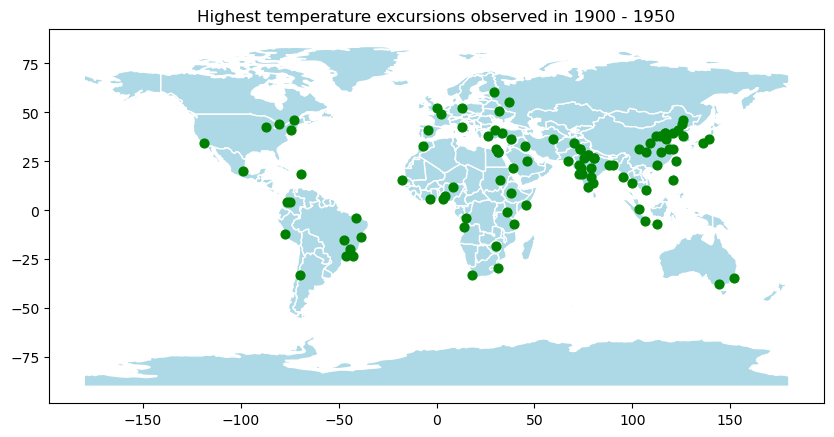

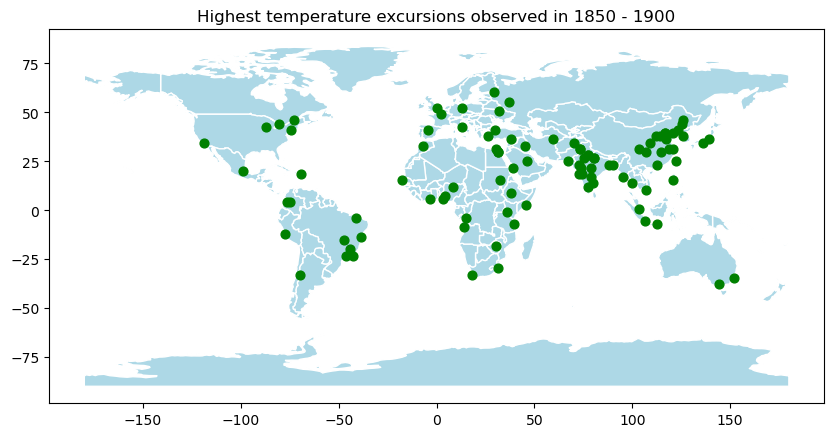

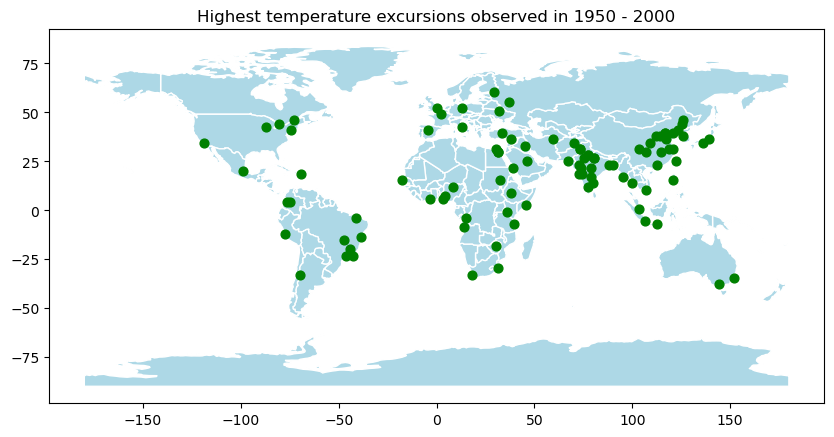

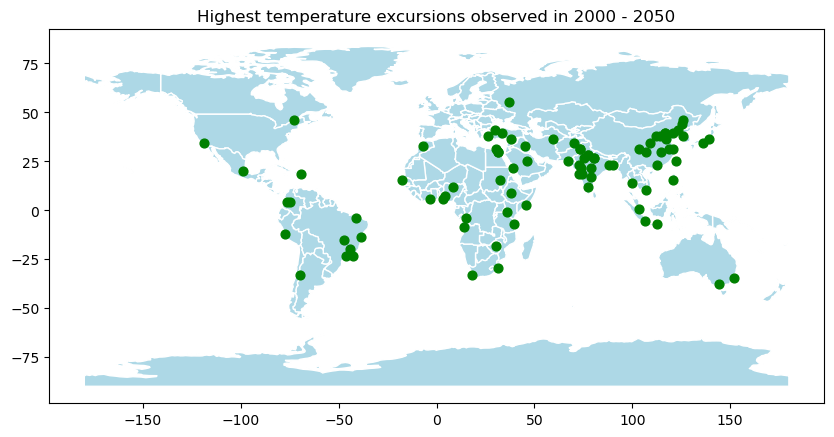

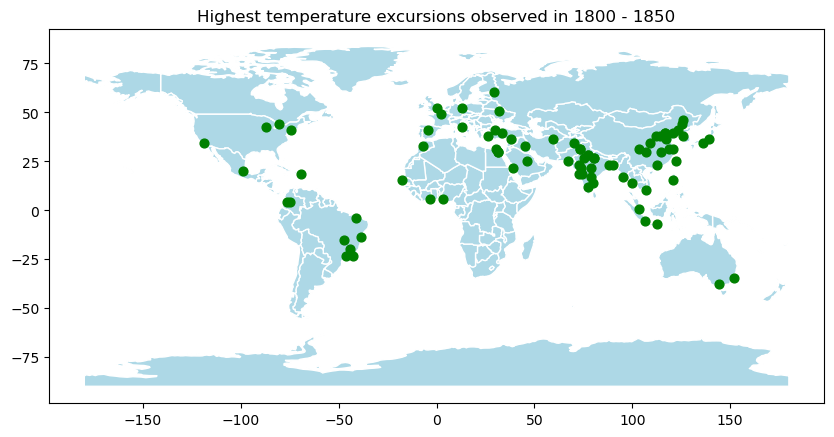

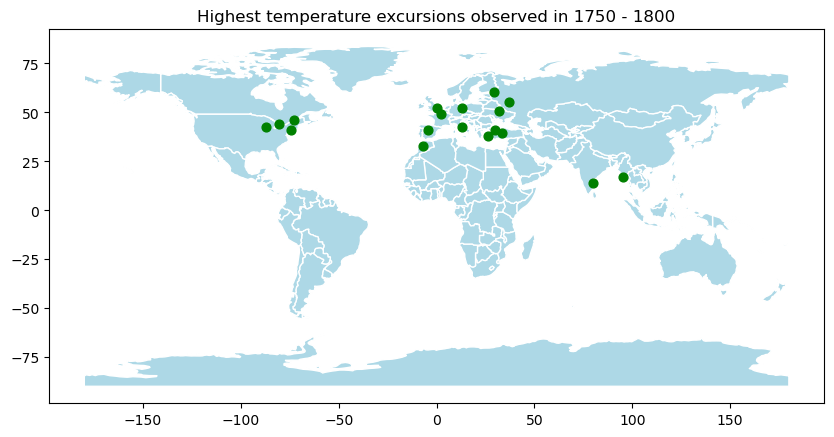

In [16]:
temp_exc_by_period(df_groups, 50)

<h1> SECONDA PARTE </h1>

In [17]:
#osservo il geodataframe
gdf

,Date,AvgTemp,AvgTempUnc,City,Country,Latitude,Longitude,Year,geometry
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63,-3.23,1849,POINT (-3.23000 5.63000)
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63,-3.23,1849,POINT (-3.23000 5.63000)
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63,-3.23,1849,POINT (-3.23000 5.63000)
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63,-3.23,1849,POINT (-3.23000 5.63000)
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63,-3.23,1849,POINT (-3.23000 5.63000)
...,...,...,...,...,...,...,...,...,...
239171,2013-04-01,12.563,1.823,Xian,China,34.56,108.97,2013,POINT (108.97000 34.56000)
239172,2013-05-01,18.979,0.807,Xian,China,34.56,108.97,2013,POINT (108.97000 34.56000)
239173,2013-06-01,23.522,0.647,Xian,China,34.56,108.97,2013,POINT (108.97000 34.56000)
239174,2013-07-01,25.251,1.042,Xian,China,34.56,108.97,2013,POINT (108.97000 34.56000)


In [18]:
# elenco tutte le città disponibili nel dataset
cities = np.unique(df_groups['City'])
print(cities)

['Abidjan' 'Addis Abeba' 'Ahmadabad' 'Aleppo' 'Alexandria' 'Ankara'
 'Baghdad' 'Bangalore' 'Bangkok' 'Belo Horizonte' 'Berlin' 'Bogotá'
 'Bombay' 'Brasília' 'Cairo' 'Calcutta' 'Cali' 'Cape Town' 'Casablanca'
 'Changchun' 'Chengdu' 'Chicago' 'Chongqing' 'Dakar' 'Dalian'
 'Dar Es Salaam' 'Delhi' 'Dhaka' 'Durban' 'Faisalabad' 'Fortaleza' 'Gizeh'
 'Guangzhou' 'Harare' 'Harbin' 'Ho Chi Minh City' 'Hyderabad' 'Ibadan'
 'Istanbul' 'Izmir' 'Jaipur' 'Jakarta' 'Jiddah' 'Jinan' 'Kabul' 'Kano'
 'Kanpur' 'Karachi' 'Kiev' 'Kinshasa' 'Lagos' 'Lahore' 'Lakhnau' 'Lima'
 'London' 'Los Angeles' 'Luanda' 'Madras' 'Madrid' 'Manila' 'Mashhad'
 'Melbourne' 'Mexico' 'Mogadishu' 'Montreal' 'Moscow' 'Nagoya' 'Nagpur'
 'Nairobi' 'Nanjing' 'New Delhi' 'New York' 'Paris' 'Peking' 'Pune'
 'Rangoon' 'Rio De Janeiro' 'Riyadh' 'Rome' 'Saint Petersburg' 'Salvador'
 'Santiago' 'Santo Domingo' 'Seoul' 'Shanghai' 'Shenyang' 'Singapore'
 'Surabaya' 'Surat' 'Sydney' 'São Paulo' 'Taipei' 'Taiyuan' 'Tangshan'
 'Tianjin' 'Toky

In [19]:
# definisco una funzione che trova il percorso spostandosi di 3 città in 3 città e andando verso quella con temperatura 
# media maggiore
# N.B. Funziona solo se start_city si trova a ovest di dest_city

def hottest_path(start_city, dest_city, year):
    
    # creo una lista nella quale inserire il percorso 
    path = [start_city]
    curr_city = start_city
    
    # modifico il dataset per considerare la temperatura media di ogni anno
    gdf['Year'] = pd.to_datetime(gdf['Date']).dt.year
    gdf_year = gdf[gdf['Year'] == year]
    gdf_grouped = gdf_year.groupby(['Year', 'City', 'Latitude', 'Longitude'])['AvgTemp'].mean().reset_index()
    gdf_grouped = gpd.GeoDataFrame(gdf_grouped, geometry=gpd.points_from_xy(gdf_grouped['Longitude'], gdf_grouped['Latitude']))
   
    #continuo finchè non raggiungo la destinazione
    while curr_city != dest_city: 
        # trovo le coordinate della città attuale
        curr_geom = gdf_grouped.loc[gdf_grouped['City'] == curr_city, 'geometry'].iloc[0]
        
        # calcolo la distanza della città attiale da tutte le altre
        gdf_grouped['distance'] = gdf_grouped.geometry.distance(curr_geom)
        
        # vado solo in una direzione, verso ovest 
        west_cities = gdf_grouped[gdf_grouped['Longitude'] < curr_geom.x]
        
        # trovo le 3 città più vicine
        nearest_cities = west_cities.sort_values('distance').head(3)[['City', 'distance', 'AvgTemp']]
        
        # considero solo la città con temperatura media maggiore
        next_city = nearest_cities.sort_values('AvgTemp', ascending=False).iloc[0]['City']
        
        # inserisco la città selezionata nella lista contenente il percorso
        path.append(next_city)
        
        # stabilisco la città selezionata come prossimo punto di partenza
        curr_city = next_city

    # creo un nuovo GeoDataSet contenente solo le città inserite nel percorso
    filtered_gdf = gdf_grouped[gdf_grouped['City'].isin(path)]

    # plotto la mappa contenente le città individuate 
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(figsize=(10, 8), edgecolor='white', facecolor='lightblue')
    filtered_gdf.plot(ax=ax, color='green', markersize=40)
    plt.title(f'Hottest path from {start_city} to {dest_city} in {year}')
    plt.show()
    print(path)

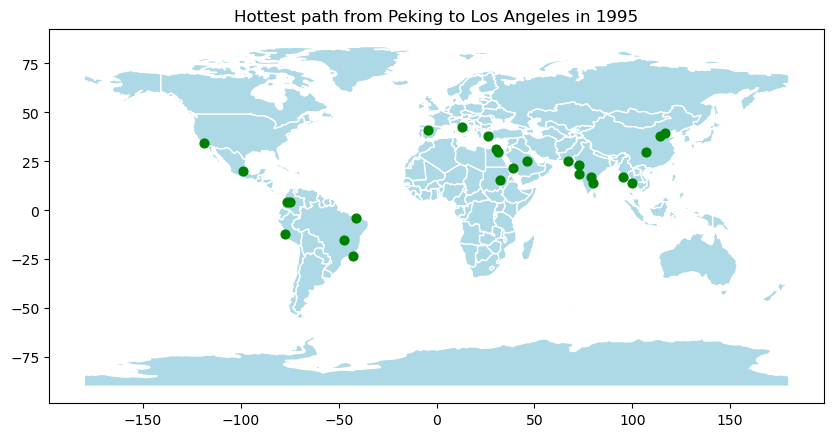

['Peking', 'Tangshan', 'Chongqing', 'Bangkok', 'Rangoon', 'Madras', 'Hyderabad', 'Bombay', 'Ahmadabad', 'Karachi', 'Riyadh', 'Jiddah', 'Umm Durman', 'Cairo', 'Alexandria', 'Izmir', 'Rome', 'Madrid', 'Fortaleza', 'Rio De Janeiro', 'Brasília', 'Bogotá', 'Cali', 'Lima', 'Mexico', 'Los Angeles']


In [20]:
hottest_path('Peking', 'Los Angeles', 1995)

In [21]:
# definisco una funzione che trova il percorso spostandosi di 3 città in 3 città e andando verso quella con temperatura 
# media maggiore considerando l'arco temporale desiderato 
# N.B. Funziona solo se start_city si trova a ovest di dest_city

def path_interval(start_city, dest_city, start_year, final_year):
    # creo una lista nella quale inserire il percorso 
    path = [start_city]
    curr_city = start_city

    # modifico il dataset inserendo una condizione che tenga conto del periodo temporale indicato
    gdf['Year'] = pd.to_datetime(gdf['Date']).dt.year
    gdf_year = gdf[(gdf['Year'] >= start_year) & (gdf['Year'] <= final_year)]
    gdf_avg_temp= gdf_year.groupby(['City', 'Latitude', 'Longitude'])['AvgTemp'].mean().reset_index()
    gdf_fin = gpd.GeoDataFrame(gdf_avg_temp, geometry=gpd.points_from_xy(gdf_avg_temp['Longitude'], gdf_avg_temp['Latitude']))
   
    while curr_city != dest_city: 
        curr_geom = gdf_fin.loc[gdf_fin['City'] == curr_city, 'geometry'].iloc[0]
        gdf_fin['distance'] = gdf_fin.geometry.distance(curr_geom)
        west_cities = gdf_fin[gdf_fin['Longitude'] < curr_geom.x]
        nearest_cities = west_cities.sort_values('distance').head(3)[['City', 'distance', 'AvgTemp']]
        next_city = nearest_cities.sort_values('AvgTemp', ascending=False).iloc[0]['City']
        path.append(next_city)
        curr_city = next_city

    
    filtered_gdf = gdf_fin[gdf_fin['City'].isin(path)]


    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(figsize=(10, 8), edgecolor='white', facecolor='lightblue')
    filtered_gdf.plot(ax=ax, color='green', markersize=40)
    plt.title(f'Hottest path from {start_city} to {dest_city} from {start_year} to {final_year}')
    plt.show()
    print(path)

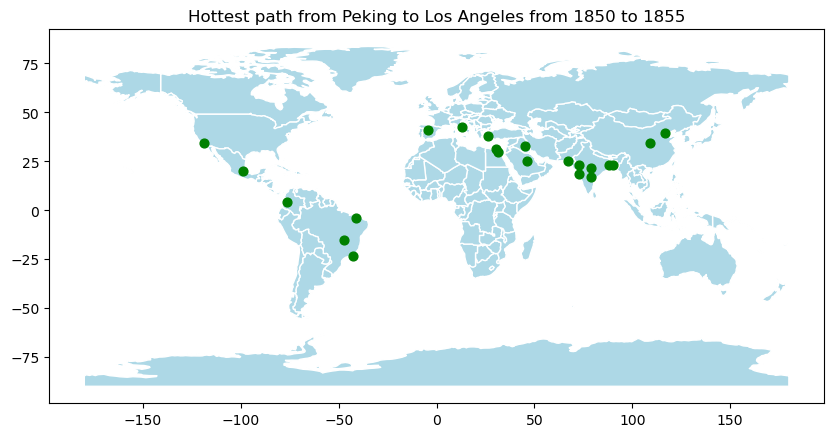

['Peking', 'Xian', 'Dhaka', 'Calcutta', 'Nagpur', 'Hyderabad', 'Bombay', 'Ahmadabad', 'Karachi', 'Riyadh', 'Baghdad', 'Gizeh', 'Alexandria', 'Izmir', 'Rome', 'Madrid', 'Fortaleza', 'Rio De Janeiro', 'Brasília', 'Cali', 'Mexico', 'Los Angeles']


In [22]:
path_interval('Peking', 'Los Angeles', 1850, 1855)

In [23]:
def path_eastwest(start_city, dest_city, start_year, final_year):
    
    # creo una lista nella quale inserire il percorso 
    path = [start_city]
    curr_city = start_city

     # modifico il dataset per considerare la temperatura media di ogni anno
    gdf['Year'] = pd.to_datetime(gdf['Date']).dt.year
    gdf_year = gdf[(gdf['Year'] >= start_year) & (gdf['Year'] <= final_year)]
    gdf_avg_temp= gdf_year.groupby(['City', 'Latitude', 'Longitude'])['AvgTemp'].mean().reset_index()
    gdf_fin = gpd.GeoDataFrame(gdf_avg_temp, geometry=gpd.points_from_xy(gdf_avg_temp['Longitude'], gdf_avg_temp['Latitude']))
    
    # creo una copia del dataset che utilizzo per la ricerca delle città
    gds = gdf_fin.copy()
    
    # trovo la longitudine della città di destinazione
    dest_longitude = gdf_fin[gdf_fin['City'] == dest_city]['Longitude'].iloc[0]
    
    #continuo finchè non raggiungo la destinazione
    while curr_city != dest_city: 
        
            #print('start', curr_city, type(curr_city))
            # trovo le coordinate della città attuale 
            curr_geom = gds.loc[gds['City'] == curr_city, 'geometry'].iloc[0]
            
            # calcolo la distanza della città attiale da tutte le altre
            gds['distance'] = gds.geometry.distance(curr_geom)
            
            # trovo la longitudine della città corrente
            curr_longitude = gds[gds['City'] == curr_city]['Longitude'].iloc[0]
            
            # elimino dal dataset currenti city in modo da non everla come tappa disponibile per le prossime ricerche 
            gds = gds.drop(gds[gds["City"]==curr_city].index)
            
            # se vado verso est considero solo le città a est e viceversa se vado a verso ovest
            if curr_longitude < dest_longitude: 
                remaining_cities = gds[gds['Longitude'] > curr_longitude]  
            else: 
                remaining_cities = gds[gds['Longitude'] < curr_longitude]    
            
            # trovo le 3 città più vicine
            nearest_cities = remaining_cities.sort_values('distance').head(3)[['City', 'distance', 'AvgTemp']]
            
            # se la destinazione è fra le città selezionate mi fermo
            if dest_city in nearest_cities['City'].values:
                next_city = dest_city
            # altrimenti continuo a cercare
            else: 
                next_city = nearest_cities.sort_values('AvgTemp', ascending=False).iloc[0]['City']
                
            # inserisco la città selezionata nella lista contenente il percorso
            path.append(next_city)
            
            # stabilisco la città selezionata come prossimo punto di partenza
            curr_city = next_city
            
    
    # creo un nuovo GeoDataFrame con le città selezionate
    filtered_gdf = gdf_fin[gdf_fin['City'].isin(path)]

    # plotto la mappa
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(figsize=(10, 8), edgecolor='white', facecolor='lightblue')
    filtered_gdf.plot(ax=ax, color='green', markersize=40)
    plt.title(f'Hottest path from {start_city} to {dest_city} from {start_year} to {final_year}')
    plt.show()
    print(path)

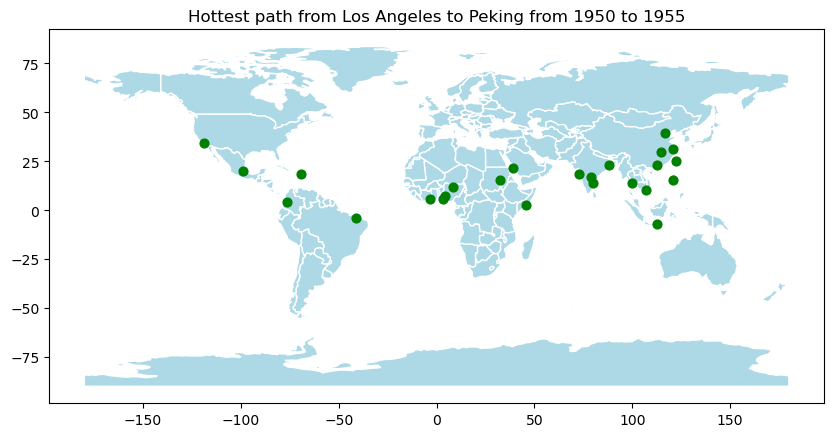

['Los Angeles', 'Mexico', 'Cali', 'Santo Domingo', 'Fortaleza', 'Abidjan', 'Lagos', 'Ibadan', 'Kano', 'Umm Durman', 'Jiddah', 'Mogadishu', 'Bombay', 'Hyderabad', 'Madras', 'Calcutta', 'Bangkok', 'Ho Chi Minh City', 'Surabaya', 'Manila', 'Guangzhou', 'Taipei', 'Wuhan', 'Shanghai', 'Peking']


In [24]:
path_eastwest('Los Angeles', 'Peking', 1950, 1955)